# CASTEP Al Slab benchmark performance

This notebook compares the performance of the small Al Slab (al3x3) benchmark across different HPC facilities.

We compute the mean time per SCF cycle from all cycles in the output file apart from the fastest and slowest cycle times. Performance is plotted as SCF cycles per second.

## Setup section

Import the required modules and define useful functions.

In [18]:
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline
mpl.rcParams['figure.figsize'] = (12,6)
import seaborn as sns
sns.set(font_scale=1.5, context="paper", style="white", font="serif")

In [19]:
import sys
sys.path.append('../../../python-modules')

In [20]:
from appanalysis import castep

## Setup data locations

### Cirrus

In [21]:
cirruscpn = 36
cirrusfiles = {1:'../al3x3/results/Cirrus/16.11_intel17_mpt214/al3x3.castep.1nodes',
                  2:'../al3x3/results/Cirrus/16.11_intel17_mpt214/al3x3.castep.2nodes',
                  4:'../al3x3/results/Cirrus/16.11_intel17_mpt214/al3x3.castep.4nodes',
                  8:'../al3x3/results/Cirrus/16.11_intel17_mpt214/al3x3.castep.8nodes',
                  16:'../al3x3/results/Cirrus/16.11_intel17_mpt214/al3x3.castep.16nodes'}

### Thomas

In [22]:
thomascpn = 24
thomasfiles = {1:'../al3x3/results/Thomas/al3x3.castep.1nodes',
               2:'../al3x3/results/Thomas/al3x3.castep.2nodes',
               4:'../al3x3/results/Thomas/al3x3.castep.4nodes',
               8:'../al3x3/results/Thomas/al3x3.castep.8nodes',
               16:'../al3x3/results/Thomas/al3x3.castep.16nodes'}

### Athena

In [23]:
athenacpn = 28
athenafiles = {1:'../al3x3/results/Athena/al3x3.castep.1nodes',
               2:'../al3x3/results/Athena/al3x3.castep.2nodes',
               4:'../al3x3/results/Athena/al3x3.castep.4nodes.201805280948',
               8:'../al3x3/results/Athena/al3x3.castep.8nodes',
               16:'../al3x3/results/Athena/al3x3.castep.16nodes.201805281048'}

### ARCHER

In [24]:
archercpn = 24
archerfiles = {1:'../al3x3/results/ARCHER/al3x3.castep.1nodes',
               2:'../al3x3/results/ARCHER/al3x3.castep.2nodes',
               4:'../al3x3/results/ARCHER/al3x3.castep.4nodes',
               8:'../al3x3/results/ARCHER/al3x3.castep.8nodes',
               16:'../al3x3/results/ARCHER/al3x3.castep.16nodes',}

### CSD3-Skylake

In [25]:
csd3scpn = 32
csd3sfiles = {1:'../al3x3/results/CSD3-Skylake/al3x3.castep.1nodes',
                2:'../al3x3/results/CSD3-Skylake/al3x3.castep.2nodes_201805280948',
                4:'../al3x3/results/CSD3-Skylake/al3x3.castep.4nodes_201802262057',
                8:'../al3x3/results/CSD3-Skylake/al3x3.castep.8nodes',
                16:'../al3x3/results/CSD3-Skylake/al3x3.castep.16nodes',}

### Tesseract

In [26]:
tesscpn = 24
tessfiles = {1:'../al3x3/results/Tesseract/al3x3_1nodes_201805161608.castep',
             2:'../al3x3/results/Tesseract/al3x3_2nodes_201805170821.castep',
             4:'../al3x3/results/Tesseract/al3x3_4nodes_201805170836.castep',
             8:'../al3x3/results/Tesseract/al3x3_8nodes_201805170854.castep',
             16:'../al3x3/results/Tesseract/al3x3_16nodes_201805171314.castep',
            }

## Process data

In [27]:
cirrusnodes, cirrusscf, cirrusperf = castep.calcperf(cirrusfiles, cirruscpn)

          Nodes           Cores    Mean SCF (s) Performance (SCF cycles/s)
          =====           =====    ============ ==========================
              1              36           102.4                   0.009764
              2              72            50.0                   0.019982
              4             144            31.4                   0.031879
              8             288            20.3                   0.049179
             16             576            20.7                   0.048335


In [28]:
thomasnodes, thomasscf, thomasperf = castep.calcperf(thomasfiles, thomascpn)

          Nodes           Cores    Mean SCF (s) Performance (SCF cycles/s)
          =====           =====    ============ ==========================
              1              24           123.3                   0.008109
              2              48            52.9                   0.018912
              4              96            30.0                   0.033382
              8             192            18.7                   0.053430
             16             384            17.3                   0.057745


In [29]:
athenanodes, athenascf, athenaperf = castep.calcperf(athenafiles, athenacpn)

          Nodes           Cores    Mean SCF (s) Performance (SCF cycles/s)
          =====           =====    ============ ==========================
              1              28           100.6                   0.009940
              2              56            48.7                   0.020530
              4             112            25.5                   0.039145
              8             224            15.2                   0.065784
             16             448            14.5                   0.069079


In [30]:
archernodes, archerscf, archerperf = castep.calcperf(archerfiles, archercpn)

          Nodes           Cores    Mean SCF (s) Performance (SCF cycles/s)
          =====           =====    ============ ==========================
              1              24           184.2                   0.005429
              2              48            88.2                   0.011341
              4              96            51.3                   0.019480
              8             192            33.2                   0.030145
             16             384            28.8                   0.034719


In [31]:
csd3snodes, csd3sscf, csd3sperf = castep.calcperf(csd3sfiles, csd3scpn)

          Nodes           Cores    Mean SCF (s) Performance (SCF cycles/s)
          =====           =====    ============ ==========================
              1              32            60.9                   0.016413
              2              64            31.7                   0.031521
              4             128            20.0                   0.049991
              8             256            13.7                   0.073073
             16             512            11.5                   0.087203


In [32]:
tessnodes, tessscf, tessperf = castep.calcperf(tessfiles, tesscpn)

          Nodes           Cores    Mean SCF (s) Performance (SCF cycles/s)
          =====           =====    ============ ==========================
              1              24           125.7                   0.007958
              2              48            68.5                   0.014606
              4              96            33.5                   0.029824
              8             192            20.0                   0.049959
             16             384            16.0                   0.062368


## Performance Comparison

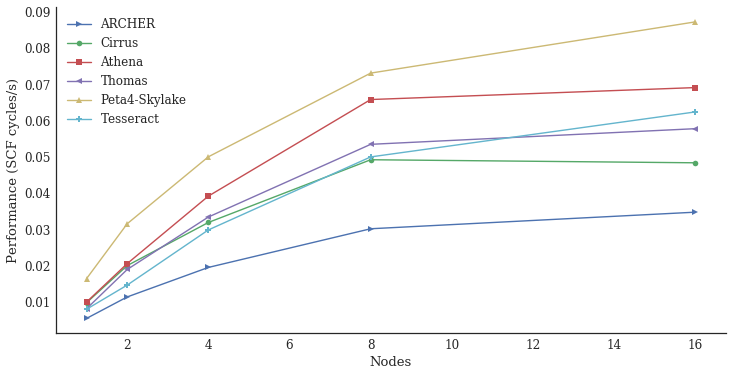

In [35]:
plt.plot(archernodes, archerperf, '>-', label='ARCHER')
plt.plot(cirrusnodes, cirrusperf, 'o-', label='Cirrus')
plt.plot(athenanodes, athenaperf, 's-', label='Athena')
plt.plot(thomasnodes, thomasperf, '<-', label='Thomas')
plt.plot(csd3snodes, csd3sperf, '^-', label='Peta4-Skylake')
plt.plot(tessnodes, tessperf, 'P-', label='Tesseract')
plt.xlabel('Nodes')
plt.ylabel('Performance (SCF cycles/s)')
plt.legend(loc='best')
sns.despine()
plt.savefig('castep_al3x3perf.png', dpi=300)

## Single node performance comparisons

In [34]:
nperf = {}
cperf = {}
nperf['ARCHER'] = archerscf[0]
cperf['ARCHER'] = archerscf[0]/(archercpn)
nperf['Cirrus'] = cirrusscf[0]
cperf['Cirrus'] = cirrusscf[0]/(cirruscpn)
nperf['Thomas'] = thomasscf[0]
cperf['Thomas'] = thomasscf[0]/(thomascpn)
nperf['Athena'] = athenascf[0]
cperf['Athena'] = athenascf[0]/(athenacpn)
nperf['Peta4-Skylake'] = csd3sscf[0]
cperf['Peta4-Skylake'] = csd3sscf[0]/(csd3scpn)
nperf['Tesseract'] = tessscf[0]
cperf['Tesseract'] = tessscf[0]/(tesscpn)

print("Performance improvement relative to ARCHER:\n")
print("{:>15s} {:>15s} {:>15s}".format('System', 'Mean SCF (s)', 'Improvement'))
print("{:>15s} {:>15s} {:>15s}".format('======', '============', '==========='))
print("1 node (per node)")
for system in sorted(nperf):
    print("{:>15s} {:>15.3f} {:>15.3f}".format(system, nperf[system], nperf['ARCHER']/nperf[system]))

print("per-core")
for system in sorted(cperf):
    print("{:>15s} {:>15.3f} {:>15.3f}".format(system, cperf[system], cperf['ARCHER']/cperf[system]))

Performance improvement relative to ARCHER:

         System    Mean SCF (s)     Improvement
         ======    ============     ===========
1 node (per node)
         ARCHER         184.184           1.000
         Athena         100.600           1.831
         Cirrus         102.421           1.798
  Peta4-Skylake          60.929           3.023
      Tesseract         125.660           1.466
         Thomas         123.312           1.494
per-core
         ARCHER           7.674           1.000
         Athena           3.593           2.136
         Cirrus           2.845           2.697
  Peta4-Skylake           1.904           4.031
      Tesseract           5.236           1.466
         Thomas           5.138           1.494
